In [13]:
"""
trying to run bandits and see the performance of the estimator.

"""

using Infiltrator
using ProgressMeter
using Plots
plotly()

include("./KjBandits.jl")
include("./KjFunctions.jl")


algo_factory (generic function with 1 method)

### All-best

In [14]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "allbest", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
# estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=NaN)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        for i in 1:K
            algo.n_pulls[i] = opt.N
            rewards = problem.μ[i] .+ sqrt(problem.σ²)*randn(problem.rngs[i], opt.N) 
            algo.sum_rewards[i] = sum(rewards) 
        end 
        
        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)


estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "allbest", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


9×6 Matrix{Float64}:
 0.027691    0.0760074  0.027691    0.145211  0.111843  0.0289914
 0.0195428   0.0760074  0.0195428   0.170439  0.119099  0.0207193
 0.0138135   0.0760074  0.0138135   0.20964   0.140221  0.0149144
 0.00982751  0.0760074  0.00982751  0.235649  0.148517  0.0112738
 0.00700541  0.0760074  0.00700541  0.260491  0.157023  0.00835782
 0.00535099  0.0760074  0.00535099  0.283551  0.163172  0.00646112
 0.00364966  0.0760074  0.00364966  0.306374  0.170492  0.00470105
 0.00240343  0.0760074  0.00240343  0.325486  0.175398  0.00341917
 0.00171624  0.0760074  0.00171624  0.345647  0.182701  0.00273165

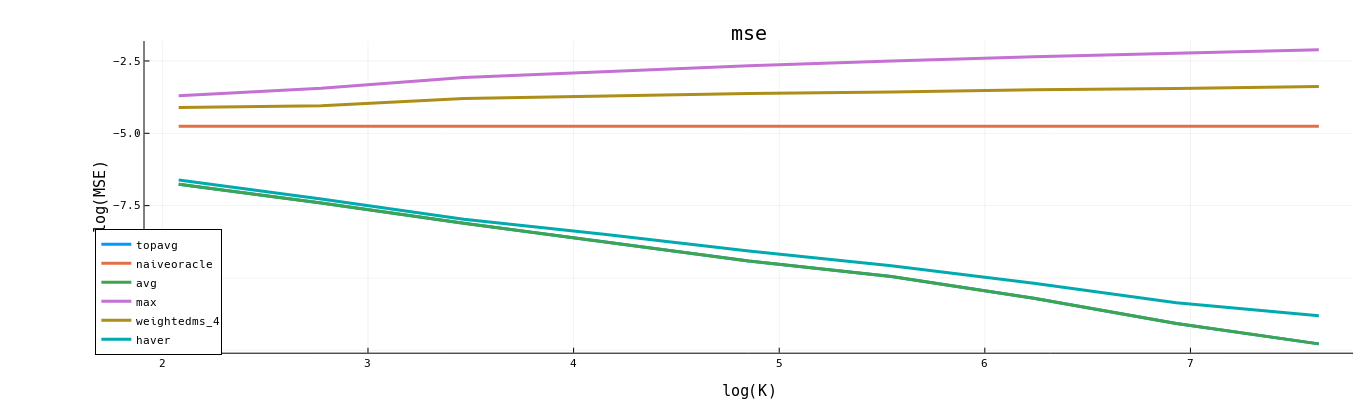

In [11]:


x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

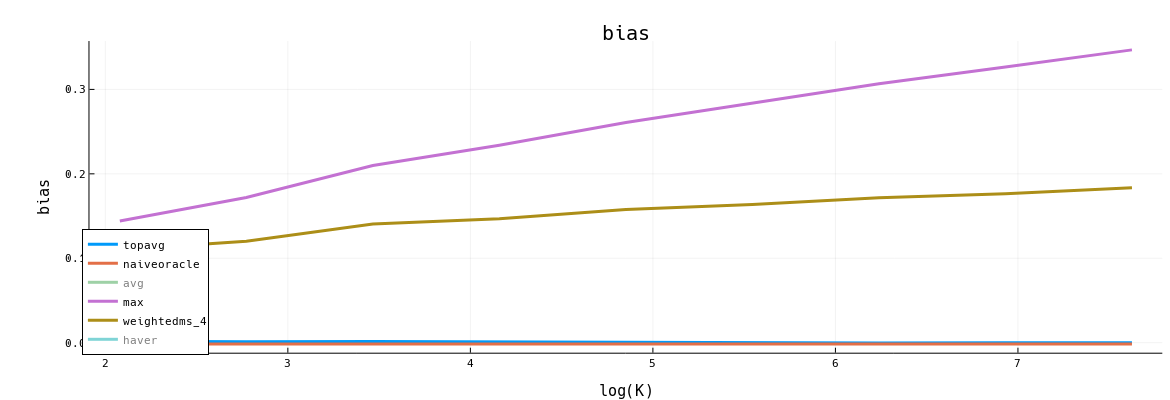

In [10]:
x = opt.K_ary
i = 1; plot(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:bottomleft)  
title!("bias")

### Alpha-fraction-single-gap, alpha = 0.6